**Import Libraries**

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from typing import List, Tuple
import os


**Load files**

In [28]:
def load_files_from_folder(folder_path: str):
    tsp_files = []
    problems_file = None
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if filename.endswith(".tsp"):
            tsp_files.append(file_path)
        elif filename.endswith(".problems"):
            problems_file = file_path
    if not tsp_files or not problems_file:
        raise ValueError("Folder must contain both .tsp files and a .problems file.")
    return tsp_files, problems_file


**Load Problem Data**

In [29]:
def load_problems_data(problems_file: str):
    problem_data = {}
    with open(problems_file, 'r') as f:
        for line in f:
            if '=' not in line:
                continue
            key, value = line.split('=', 1)
            problem_data[key.strip()] = value.strip()
    return problem_data


**Map Class**

In [30]:
class Map:
    def __init__(self, towns: np.ndarray):
        self.towns = towns

    @staticmethod
    def from_tsp_file(file_path: str):
        towns = []
        with open(file_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                if line.strip() == '' or line.startswith('EOF'):
                    continue
                parts = line.split()
                if len(parts) < 3:
                    continue
                try:
                    town = list(map(float, parts[1:3]))
                    towns.append(town)
                except ValueError:
                    continue
        return Map(np.array(towns))

    def get_towns_count(self):
        return len(self.towns)

    def as_numpy_array(self):
        return self.towns

    def visualize(self, solution=None):
        if solution is None:
            solution = np.arange(len(self.towns))
        plt.figure(figsize=(10, 6))
        plt.plot(self.towns[solution, 0], self.towns[solution, 1], marker='o', color='r')
        plt.plot([self.towns[solution[-1], 0], self.towns[solution[0], 0]],
                 [self.towns[solution[-1], 1], self.towns[solution[0], 1]],
                 marker='o', color='r')
        plt.title("TSP Solution Path")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.grid(True)
        plt.show()


**TravelingSalesmanProblemSolver Class**

In [31]:
class TravelingSalesmanProblemSolver:
    def __init__(self, map_: Map, generation_size: int = 100, mutate_p: float = 0.05, n_iter: int = 50):
        self.map = map_
        self.generation_size = generation_size
        self.mutate_p = mutate_p
        self.n_iter = n_iter

    def spawn(self):
        m = self.map.get_towns_count()
        n = self.generation_size
        population = [np.random.permutation(np.arange(m)) for _ in range(n)]
        return np.vstack(population)

    def evaluate(self, population: np.ndarray):
        map_ = self.map.as_numpy_array()
        scores = []
        for individual in population:
            distance = sum(
                np.linalg.norm(map_[individual[i]] - map_[individual[i + 1]])
                for i in range(len(individual) - 1)
            )
            distance += np.linalg.norm(map_[individual[-1]] - map_[individual[0]])
            scores.append(distance)
        return np.array(scores)

    def train(self):
        generation = self.spawn()
        scores = self.evaluate(generation)
        bests = []
        for _ in range(self.n_iter):
            bests.append(scores.min())
            generation, scores = self.step(generation, scores)
        bests = np.array(bests)
        solution = generation[scores.argmin()]
        return bests, solution

    def step(self, generation, scores):
        n = self.generation_size
        p = 1 / scores
        p = p / p.sum()
        new_gen = []
        for _ in range(n // 2):
            p1, p2 = self.select(generation, p)
            c1, c2 = self.crossover(p1, p2)
            c1, c2 = self.mutate(c1), self.mutate(c2)
            new_gen.extend([c1, c2])
        new_scores = self.evaluate(np.vstack(new_gen))
        all_scores = np.hstack((scores, new_scores))
        combined = np.vstack((generation, np.vstack(new_gen)))
        indices = np.argsort(all_scores)[:n]
        return combined[indices], all_scores[indices]

    def select(self, population, p):
        indices = np.arange(population.shape[0])
        selected_indices = np.random.choice(indices, 2, p=p)  # Select indices based on probabilities
        # Return the actual individuals (paths) from the population
        return population[selected_indices[0]], population[selected_indices[1]]

    def crossover(self, p1, p2):
        n = len(p1)
        split = np.random.randint(1, n - 1)
        c1 = np.concatenate([p1[:split], p2[~np.isin(p2, p1[:split])]])
        c2 = np.concatenate([p2[:split], p1[~np.isin(p1, p2[:split])]])
        return c1, c2

    def mutate(self, individual):
        if np.random.rand() <= self.mutate_p:
            swap_idx = np.random.choice(len(individual), 2, replace=False)
            individual[swap_idx[0]], individual[swap_idx[1]] = individual[swap_idx[1]], individual[swap_idx[0]]
        return individual


**Define K-Means Clustering**

In [32]:
def apply_kmeans_clustering(towns_array: np.ndarray, n_clusters: int) -> Tuple[np.ndarray, np.ndarray]:

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(towns_array)
    return kmeans.cluster_centers_, labels


**Visualization Clustering**

In [33]:
def visualize_clusters(towns_array: np.ndarray, cluster_centers: np.ndarray, labels: np.ndarray):

    plt.figure(figsize=(10, 6))
    for cluster_idx in np.unique(labels):
        cluster_points = towns_array[labels == cluster_idx]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_idx + 1}")
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], color='black', marker='x', s=100, label="Cluster Centers")
    plt.title("K-Means Clustering of Towns")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend()
    plt.grid(True)
    plt.show()



**solve TSP with K-means**

In [36]:
def solve_tsp_with_kmeans(map_: Map, n_clusters: int, generation_size: int = 100, mutate_p: float = 0.05, n_iter: int = 50):

    # Convert towns to a NumPy array for clustering
    towns_array = map_.as_numpy_array()

    # Apply K-Means clustering
    cluster_centers, labels = apply_kmeans_clustering(towns_array, n_clusters)
    visualize_clusters(towns_array, cluster_centers, labels)

    total_distance = 0
    cluster_solutions = []

    for cluster_idx in range(n_clusters):
        print(f"\nSolving TSP for Cluster {cluster_idx + 1}...")

        # Filter towns belonging to this cluster
        cluster_towns = towns_array[labels == cluster_idx]
        sub_map = Map(cluster_towns)

        # Solve TSP for the cluster using Genetic Algorithm
        solver = TravelingSalesmanProblemSolver(sub_map, generation_size, mutate_p, n_iter)
        bests, solution = solver.train()

        # Visualize solution for the cluster
        print(f"Cluster {cluster_idx + 1} Solution: {solution}")
        sub_map.visualize(solution)

        # Append cluster solution for later analysis
        cluster_solutions.append(solution)

        # Add the best distance for this cluster to total distance
        cluster_distance = bests[-1]
        total_distance += cluster_distance

        print(f"Cluster {cluster_idx + 1} Best Distance: {cluster_distance:.2f}")

    print(f"\nTotal Distance Across All Clusters: {total_distance:.2f}")

    return cluster_solutions, total_distance


Processing Map 1...


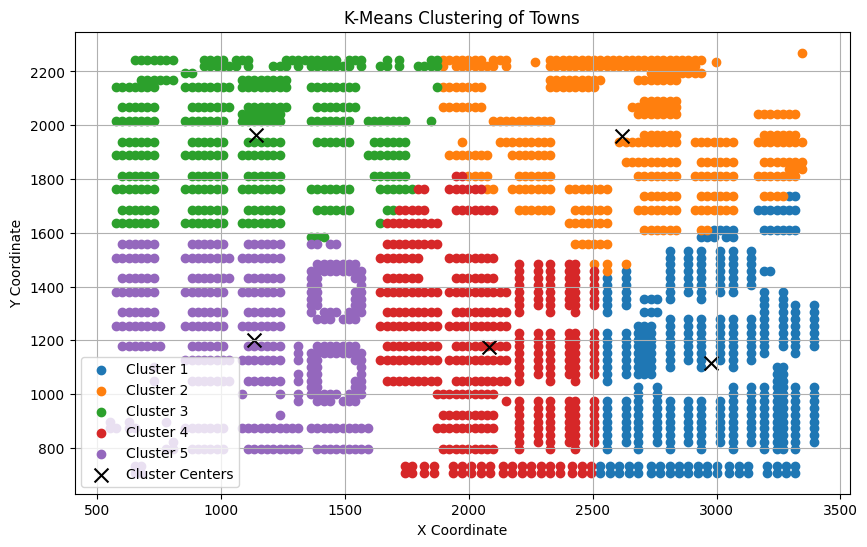


Solving TSP for Cluster 1...
Cluster 1 Solution: [336 213  41 286 190 171 247 252   3 316   6 196 152  68  75 122 306 227
 325   1 210 193 191 184 157  87  85  99 228 178 164 124 369 119 277  46
  92  79 140 345  55 111 382 194 218 207 208 166 142  62  54  52 107 344
 271 150 200 120 170 130 321 338 309 305 292 374 203 144 293 360 255 339
 100 375 297 380  25 160 108   2 307 139 148  90  60  35 302 162 324  14
 133 343 354 125 126  31  57 358 357  24   7  32 132 167 212   9 112 280
 158 222 359  23 198 123 270 331  22  89 136  91  94 151 327 296 353 288
 175  44  17 259 168 192 233  81 114 143 110 279 186 195  96 217 135  97
 117 129  74  19  61 246 299  76 361 342 147  43  67 105  34 265 261 258
 363 352 101 172  49  30 257 320 346 211 379 381 378 284  45 131  80 282
  18 109  69 376 318 349 249 348 146 149  71 319 341  15  50 187  42 295
 285 197 127  29 334 370 326 264 183 137 155  82  98 113 248 188  58  66
 241 371 330  36  27 266 367 317  40 260 103   0 290 269 301 323 311 337
 

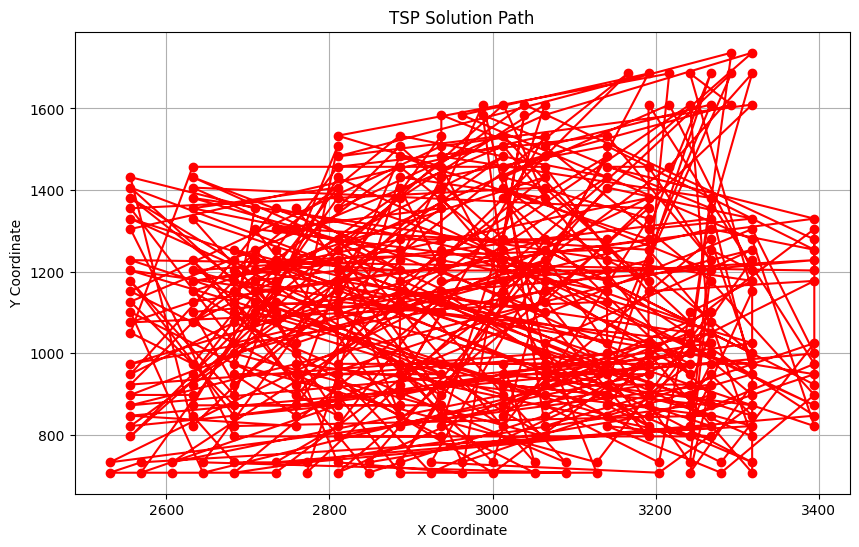

Cluster 1 Best Distance: 144312.34

Solving TSP for Cluster 2...
Cluster 2 Solution: [154  26 182   1 209 139 142 320 326 330 111 314 309 271  98 224 162 146
  34 310 305 218 207 222 171 138 246  25 180 128 319 276  53 102 134  83
 143  18  42  48 332 269 287 233 186 188 120  17 306 303 216 121 132 295
 283  10 285 355 215 239 238 205 304  51 293 307  31  45 301 104 118 197
 354 204 165 211 258 123  62  16 127  81  33 202 252 190 179 144 251 140
 212 217  69  55 344  85 155 342 288 324  82 284 296 107 183 214 169  90
   5 135  66 302 234 124 257 195 194  21 273  96 137  56 108  37  46  54
 187 308 281 244 191  14 264 221 185 260 236 230 243 126   2 338 116 130
 133 206   6  29 178 223  43  61 129 184 152  75  73  64 321 148 103  80
 334   8 156 275 328 210 250 159 189 256 136 122  36  67 300 346 299 270
  13 177 145 228 272 196 249 167  65  52 279  20 289 157 149  28 274  32
 174 263 213 291 341 345 343 340  59 352   9 158  24 161 259 245 106 113
 125  27 220 262 255 231 225 203 261 24

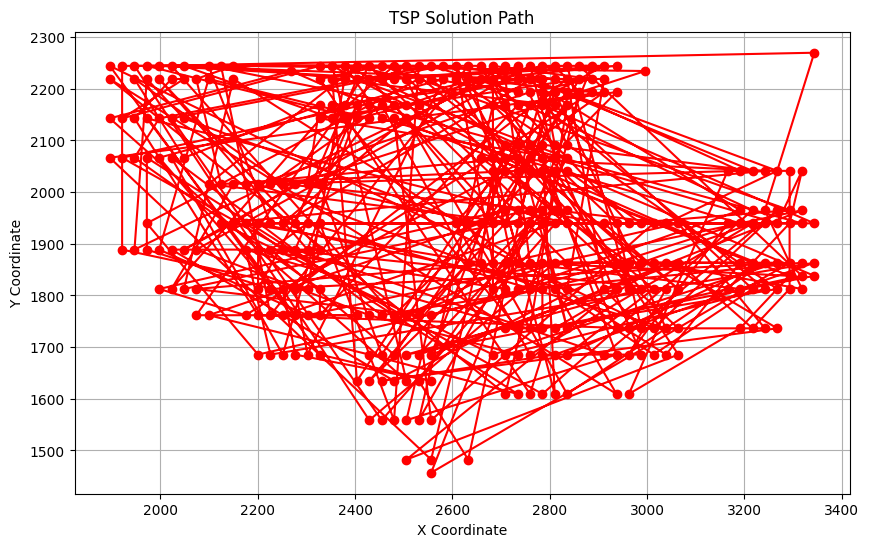

Cluster 2 Best Distance: 152371.34

Solving TSP for Cluster 3...
Cluster 3 Solution: [ 82  29  90 325 180 107 213 128 196 167 316 142 204 308 310 164  84 174
 135 228 248 251  61 149 179 312 283 315 264 118 116 144 139 178  26  36
  64   7 225 126 282  10 146 313 322  41  16 184 193  21 103 242 331 117
 186  23  96  87 265 157 295 253 256  89 185 296 206 182 218 160 203 229
 273  11  98 130 332 301 101  19 326  81 338 323  86 224 230 279 155 249
 254  63 132 287 172 171 280  79  35  54 274 246  75 247 237 190 327 151
 163 294 209 109 245 329 266  83  92 197  66 140 173 220 124 169 330 195
 133 328 136 201 285  56   9  67 105 120 222 145 108 217 165 189   0  85
 131 212 261 210 129 321 303 161   2  52 305 286 187  46 181  42  13   5
  14  65 125 263 293 143 319  62  51 127 150  58  45  38  72  57  73  12
 244 258 166 311  20  25 304 298  91  39   8  24 314 334 252 208  50 147
 272 302 309 175 119 199 138 214 114 241 202 271 156 340  97 255  88 115
  31   4 194 270 269  55 141 111 113 15

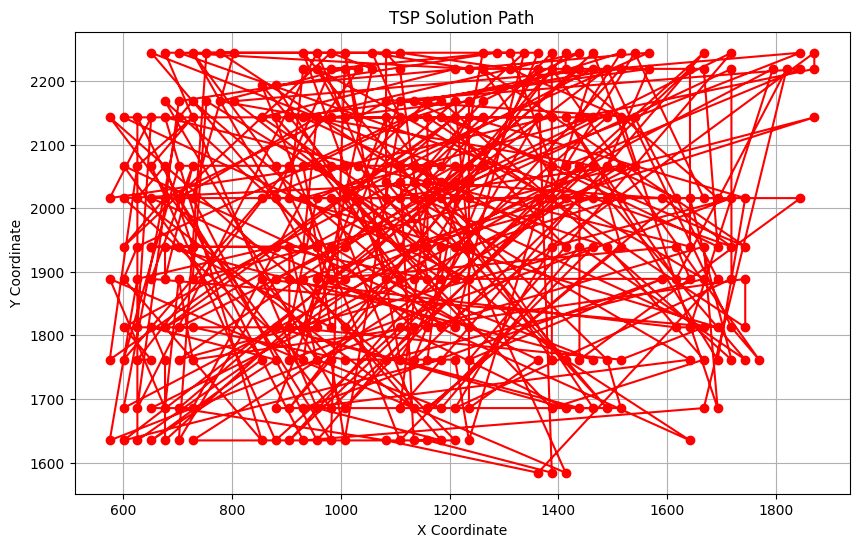

Cluster 3 Best Distance: 137818.35

Solving TSP for Cluster 4...
Cluster 4 Solution: [333 104  23 191 313  25   8 114 392 385 206  92  43 320 261 256 337  96
 356 278 386 340 210 241 229 284 195  45 296 286 265 293  98 288 170 362
 272  21 200  28 372  75 132  14 292 220 217 304  50 185 215 249 289 317
  48  27 208 145 305 186 329 331 222 252 366 203 250 237 243 389 128 194
 174 180 141   9 236   1 287 152  44  77  82  72 270 377 102 369  85 124
 117 363 240 119 144 136  10  24 295 378 213 348 307 248 134 314 374 214
 291 161 168 175 330 172 166 137 100 202  58 169 199 326 370  79  51 135
 106  97 201 281 269 376 354 105 238   2 387 260 262 273 228 359 311 301
 226 346 390 101  78 290 163   5   4  19 239 267 327 151  70  31 303 349
  18 285 324  69  62 173 182 336  89  76  49  12 235  15 299 368 282 315
 224  59  73 350 247 345  71  64 187  13  80 108 121 150  46 131   3  38
 159  86 347 212 120  74 196 179 283 364 321 190 181  60 352 266 264 205
 384 306 103  90 255 280 216 219 178  1

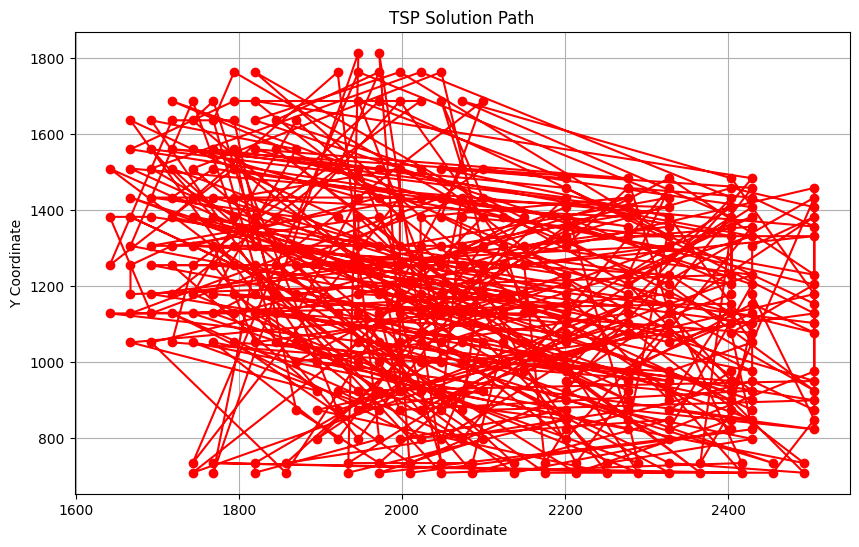

Cluster 4 Best Distance: 152928.14

Solving TSP for Cluster 5...
Cluster 5 Solution: [266 168 279 281 271 297 200 334  46  29 248 175 173 267 286 275 282 304
  70 328 186  68  33  14 190 185 100 234 184 133 207 197 131 201  60 145
  59 193 205 236  96  34 150  98 332 116 259 301 272 211  78 192 251 179
 117  45 310 203  41  10 245 169 218  13 261  97 195 115 101 239  17  27
 284 244 243  93  20   8  76  90 339 247 191 177 214 257 216 309 112 129
  32  87   7 278 295 152 254 292 263  57  66 127  79 132  77 274 226 246
 258  88 208 181  85  83 316 219 155 330 313 149 176 165 225 253 121 237
 223 322 270 269 143 283 227 305 119  92 264 311  50 326 178 265 157 180
 199   2   9 104 300 232 118   6 198 196 327 128 137  39  43 124 336 240
 209 235 230 233 229 221 151 210 136 289 134  69  28 314 174 156   4  22
 167 146 166   5  36  44 303  94  58  21  72 293  18 288  53  64  42  55
 154  63 329 340  49 147 110 290 153 163 285  38 315 142 260 312 164 183
 256 238   0 228 172  95 148 171 287   

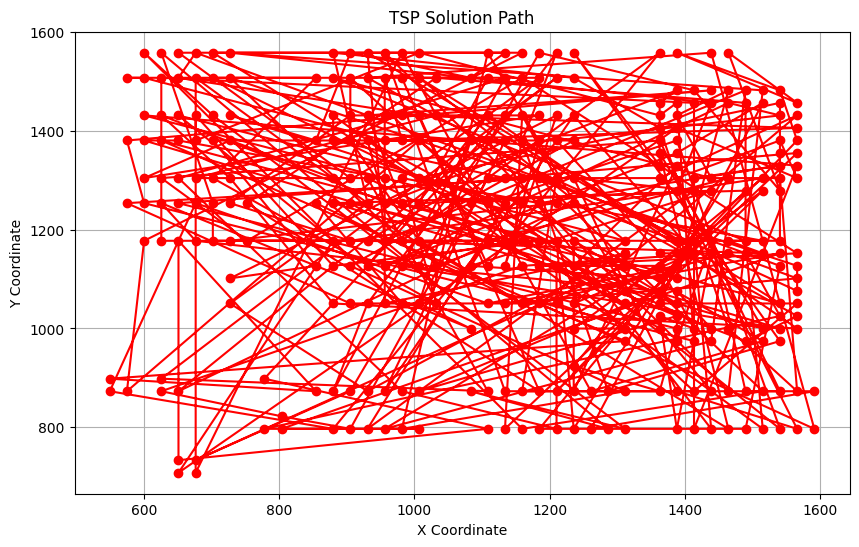

Cluster 5 Best Distance: 137248.77

Total Distance Across All Clusters: 724678.94
Processing Map 2...


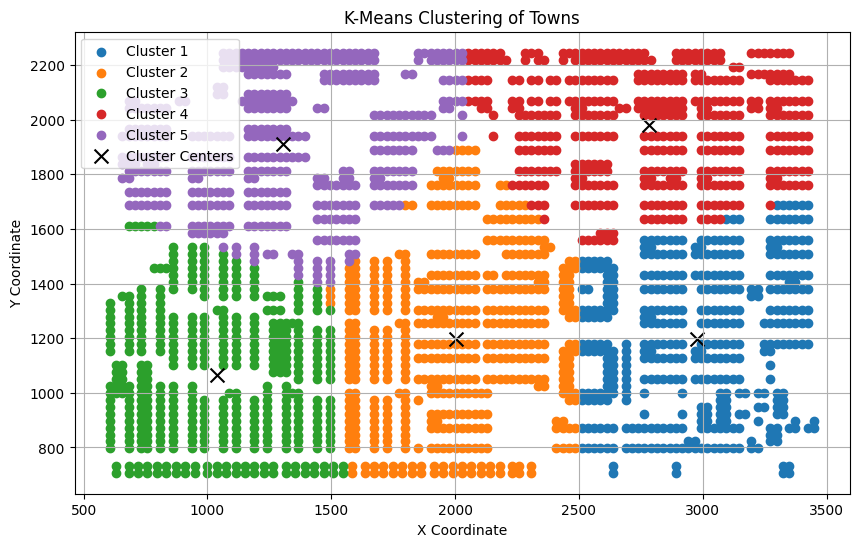


Solving TSP for Cluster 1...
Cluster 1 Solution: [394 321 143 168 342 218 340  15 118 401  22 344 166 160 241 282 392 348
 210 345 354 350 223 169 134 170 219 283   5  78 402 355   9 209 202 316
   1  87  12 242 388  41 135 288 239 311  55  50 171  67 258  77 190 262
 251 116  19  65 161 234 343  34  30 107 232 165 175  89 287 186  97 191
  13 337 212 346 351 371 381 112  48 286 147  39  21 182 325 131 317 260
  35  29 159 193 336 284 313 324 309 164 302 364 256 228 275 269 129 314
 285 123 247  17 395 113 236  64 139 211 213  84 382 266 156 248 178  32
 374 300 320 125  59 368 400 358  18  16 115 192 235 246 290 158 106   3
  31 196 338 104 245 243 250 163 124 333 306  94  46  51 279  76   7 380
 370 357 362 341  92 184 363  85  40 150 237 119 365 312   8  74 376 295
 229 307 224 225 167 389 322 151 294 230 273 272 220 215 255 180 183 379
 373  53  45 127 298 188 349 263 226 121 141 397 353  56  54 153 271 270
  52 393 126  91  33 199 105 117 330 305  66  93  95   0 174 238 254 277
 

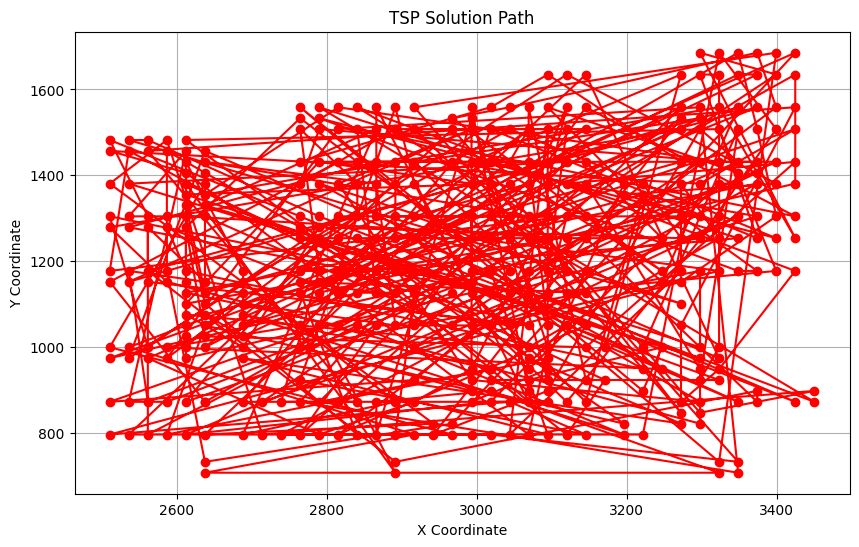

Cluster 1 Best Distance: 158667.65

Solving TSP for Cluster 2...
Cluster 2 Solution: [284 484 229 152 180 459   6 333 327 227 275 306 126 253 124 417 158 359
 344 367  39 404 311  59 108  67  58  65 135 211 444 466 247 303 149 176
 199 198 193 304 257 481 462 351  33 249 400 448 188 362 252  51 151 457
 192 442 464  83  66  16 172 288 477 201 322 365 265  97  87 281 385 441
  52  43 294 285  36 435 219 419  72 134 421 271 101  45  32 107  29 320
 371 115 177 270 295  31 460  48 144  11 409 155 479 350 436 393  13  10
 389 291 205 279 296 428 297 292  57 182 140 261 109 204 339 138 123 309
 189 133 413 184 226 137 438 401 388 113 289 290 164  60 197 178 431 244
 130 443 160 165  34 476  50  22 154  74  47 395 335 316  92 315 255   2
 384  90 106 250 398 386 374 170 469 307 276 128 102  56  21 397 342 278
   4  12 426 232 224  89 114 358 310 153 163  99 120 121 132 456 455 142
  98  93  41 450 214 329 433  79  28 474   8 422  68 148 171 240 302 357
 471 382 340 313 218 277 332 324 260 26

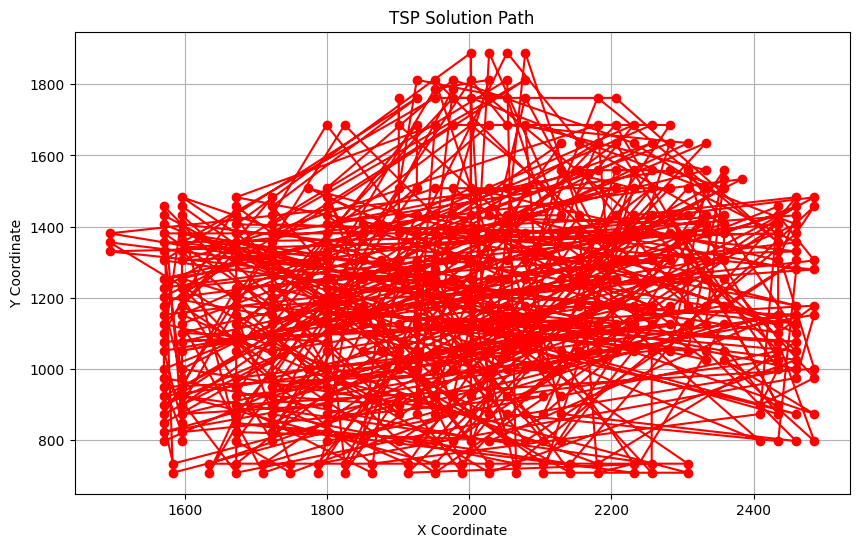

Cluster 2 Best Distance: 210317.19

Solving TSP for Cluster 3...
Cluster 3 Solution: [ 93  41  92  22  90  40 390 373  47 277 378 333   1 336 143 298 328  15
  30 171 120 215 218 400  50 415 173 302 157 319 267 279 181  64 245 348
 103  62 201 256  43 221 269  23  74 382  53 407  44 169 322   9 163 176
 248 261 287 153  34  63 366 162  81 345 295 168 329 318 156 406  59 347
 357 255 285 243 363  26 154 394 236 339 377 217  99 207 280 175 312 375
 402 238 393   3  46 172 188 369 291 107 170 137  58 265 286 330 233 371
 161 191  95 115 125 288 222 379 144 179 386 226 403  94   5  32   4 275
  75 114 152 106 343 341 301  72 178 300  79 109 408 365 352 124 149 110
 272 306 246 364 299 303 315 370 250 356 254  31 135 235  16 204 350  61
 211 199   7 388  39  78 136   8 210 223 225 198 380 360 321  48 296 230
  19 102  82  70  85  71 355 239 195 308 282  42 111 354 108 383  45 213
 206  76 372 266 234 310 145 138  14 362 326 208 126 183 332 177 278 290
 200 338 129  21 413 202 293 122 192 13

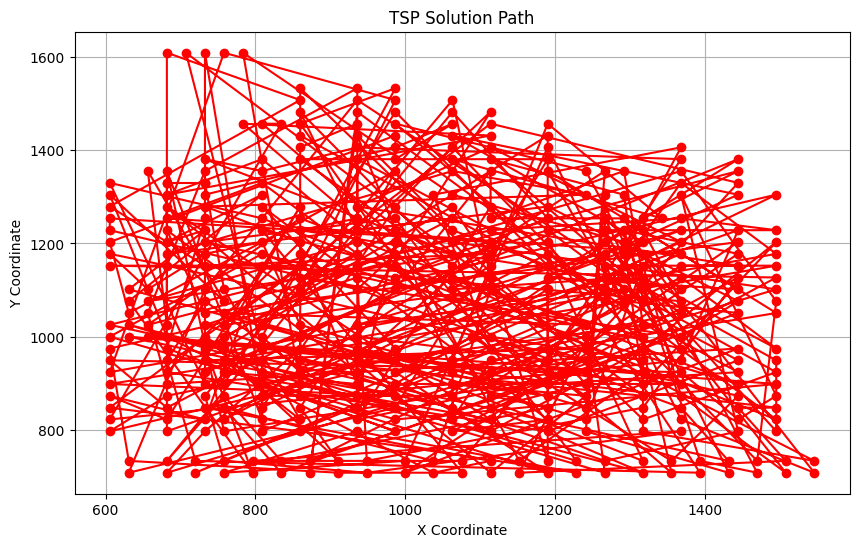

Cluster 3 Best Distance: 152651.97

Solving TSP for Cluster 4...
Cluster 4 Solution: [126 160 404 383 239 298 111  59 167 268 180 330  31 106 127  82 148 143
 154 182 336   1 157 152  94 358  33 164 211 101 263 168  86 216  96  42
 186  87  29 419 303 264 117 130  73 193  56 144 373 322 398 151 165 370
 325  22 158 116 244 233  84 171  18 177 240  26 196 403  12  16 159 353
 374 352 341 155 411  71  36  63 232 345  14  30  58 251 312  76 281  65
  24 393 318 337 124   8 109  40 320 238 295 321 187  27  51 142  49 356
 400 412 424 173 138  62 140   2  11 409 265 212 170 166 382 221 102  89
  23  50 197 231   6 228 364 136 229 343 181 401 194  66  34 399 279 387
 407 423 390 379 184 276 408 309 333 306 206 355 198 176  21 119  91 259
 103 213 134  97 225  68  80 326 290 297 362 310 215 376 335 351 308 323
 391 389 243 112 234 292 405 378 128 150 214 324 227 224  83 359 118  52
  32 110 344 271 236 410 422 270 245 421 415 200 274 188 222 208 192 388
 354 285 338  41 283  25 249  70  37 13

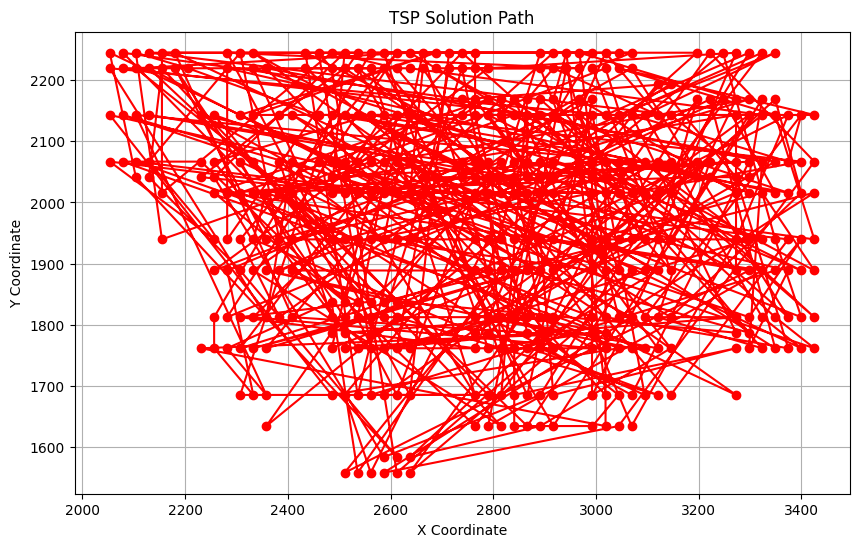

Cluster 4 Best Distance: 180812.70

Solving TSP for Cluster 5...
Cluster 5 Solution: [236 274 136 246 373 416 419 206 137  34  39  52  31  58 159  70 168 193
  12 186 307  83  84 244 398 357 348 342 355 210   1  43 324  76 144 184
 363 306 302 216  68 157 182 194 321 374  63 220 278 262 227 110 359 106
 391 294 316 126 301  91  28  87 356 346 388 284 285 328   6  37  65 393
 404 367 352  55 201 172 175 217 145 204 180 317 181 116  71  60   4 225
 205 147 199 117  29  82 215 190 154 173 155 279 263 282  11 395   9  19
 349  42  54 369  21 323  67 375  80  59 413 397  41 420  57  48  26 392
 120 249 240 191 161 273 276 312 266 264 162 385 223  14  99   5 102  62
  88 387 151 129 368 322 114 338 308 304 300 133 142 166 171 121 169 260
 179 277 140 291 127 152 360 421 418  77 344 364 238 372   3 399  38 303
  86 270 259 292 389  51  16 163 275 248  98  90 139 143 118 250 343 231
 267 187 272 254  32 334 310 362  47 339  75  78 333   0  73 131 325 326
 299 361 167 111  25 358  64 320 384 19

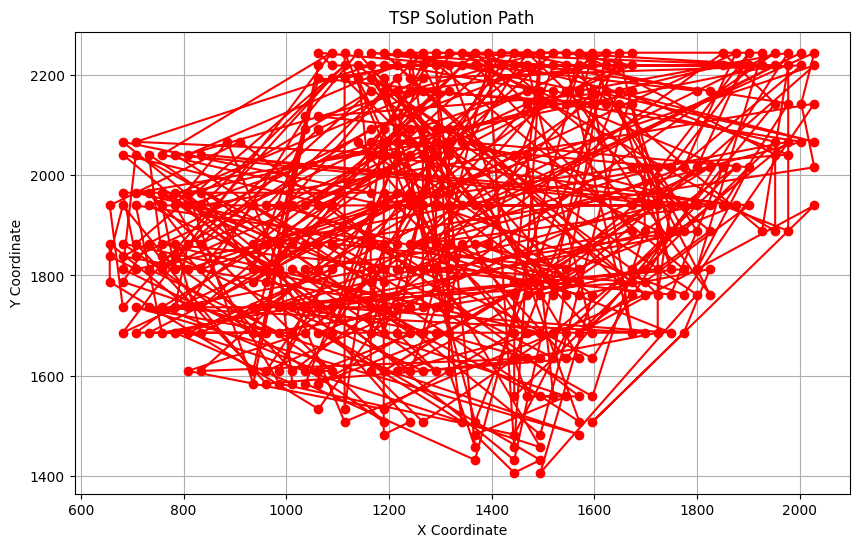

Cluster 5 Best Distance: 179965.09

Total Distance Across All Clusters: 882414.60


In [37]:
# Define the folder path and load data
folder_path = "tsplib-master"
tsp_files, problems_file = load_files_from_folder(folder_path)

# Solve CSP for each TSP file
for idx, tsp_file in enumerate(tsp_files):
    print(f"Processing Map {idx + 1}...")

    # Create the map
    map_ = Map.from_tsp_file(tsp_file)

    # Number of clusters (this can be adjusted based on problem complexity)
    n_clusters = 5

    # Solve CSP using K-Means clustering
    solve_tsp_with_kmeans(map_, n_clusters, generation_size=100, mutate_p=0.05, n_iter=50)
